In [1]:
!pip install pandas numpy scikit-learn pyarrow

In [2]:
!pip install matplotlib seaborn plotly

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from google.colab import files

In [4]:
uploaded = "/content/user-wallet-transactions.json"


In [7]:
input_filename = "/content/user-wallet-transactions.json"
output_filename = 'aave_credit_scores.json'

In [8]:
try:
    df = pd.read_json(input_filename)
except:
    with open(input_filename) as f:
       data = json.load(f)
    df = pd.DataFrame(data)


=== Transaction Type Distribution ===
action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64


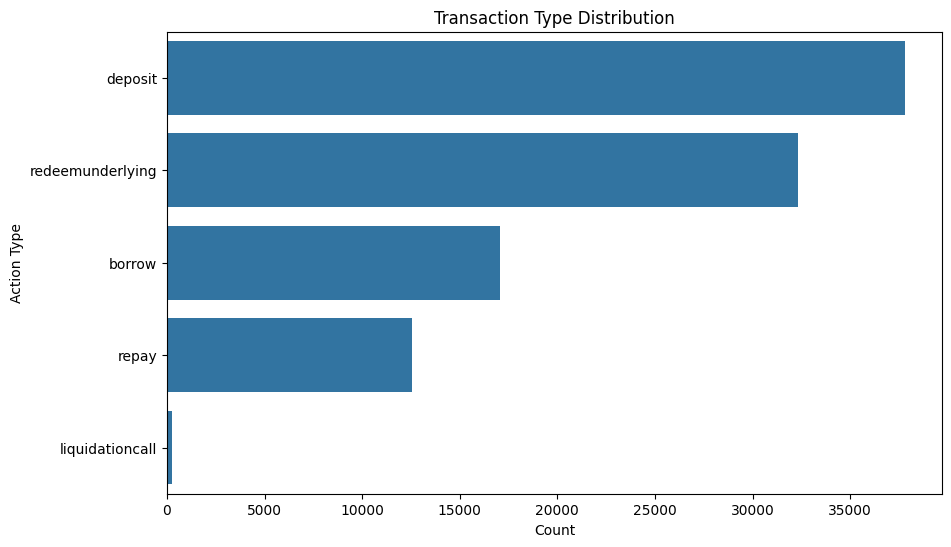

In [22]:
df['amount_usd'] = df['actionData'].apply(
    lambda x: float(x['amount']) * float(x['assetPriceUSD']) if 'assetPriceUSD' in x else 0
)

print("\n=== Transaction Type Distribution ===")
action_counts = df['action'].value_counts()
print(action_counts)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='action', order=action_counts.index)
plt.title('Transaction Type Distribution')
plt.xlabel('Count')
plt.ylabel('Action Type')
plt.show()

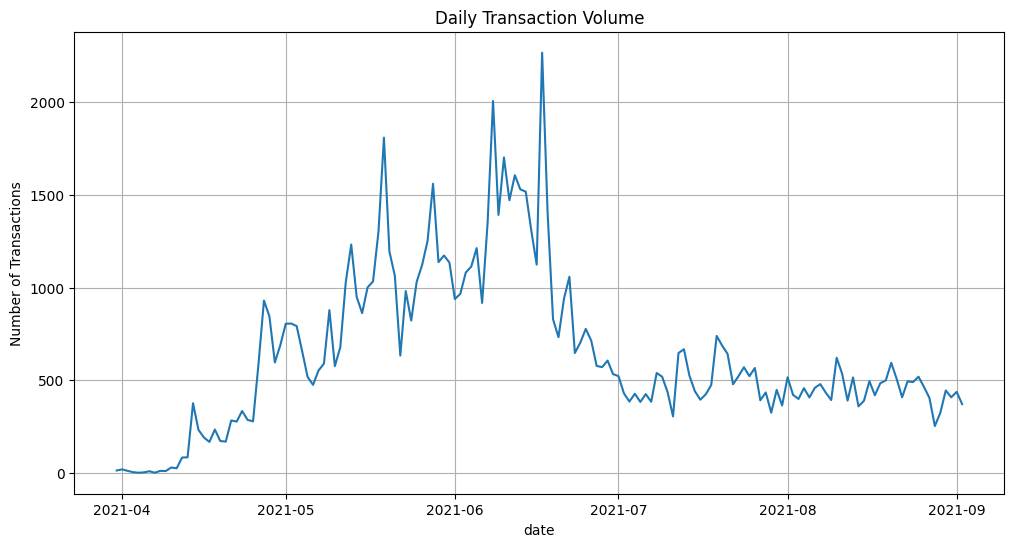

In [24]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

daily_tx = df.groupby('date').size()
plt.figure(figsize=(12, 6))
daily_tx.plot(kind='line', title='Daily Transaction Volume')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

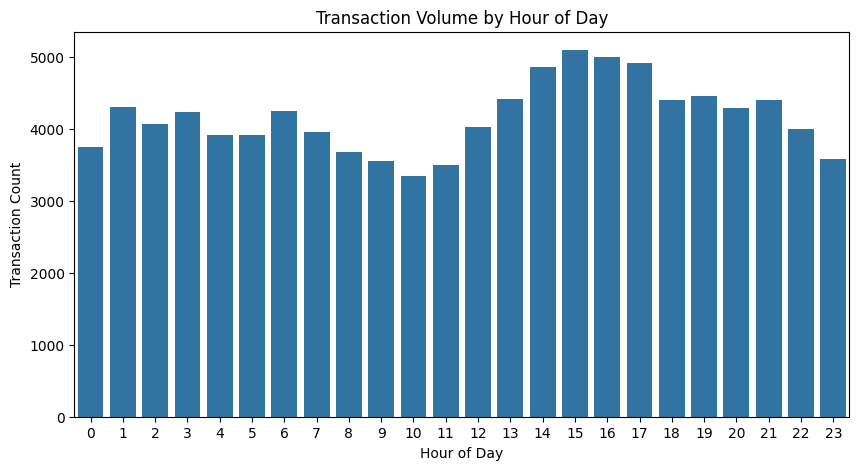

In [25]:
hourly_tx = df.groupby('hour').size()
plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_tx.index, y=hourly_tx.values)
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Count')
plt.show()


=== User Activity Summary ===
count     3497.000000
mean        28.595939
std        250.732075
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max      14265.000000
Name: count, dtype: float64


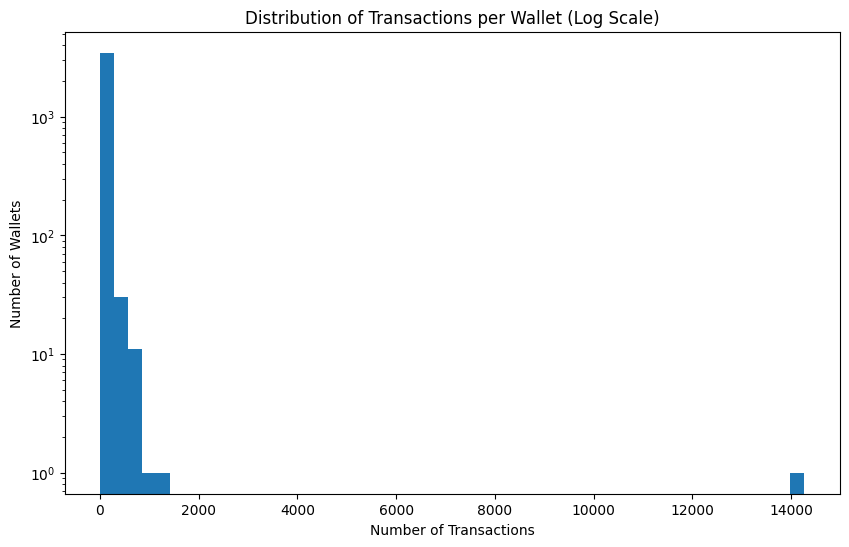

In [26]:
user_activity = df['userWallet'].value_counts().describe()
print("\n=== User Activity Summary ===")
print(user_activity)


plt.figure(figsize=(10, 6))
plt.hist(df['userWallet'].value_counts(), bins=50, log=True)
plt.title('Distribution of Transactions per Wallet (Log Scale)')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Wallets')
plt.show()


=== Financial Metrics ===
Total USD value transacted: $1,167,113,624,779,313,499,873,476,608.00
Average transaction size: $11,671,136,247,793,135,386,624.00
Median transaction size: $7,331,945,522,671.45


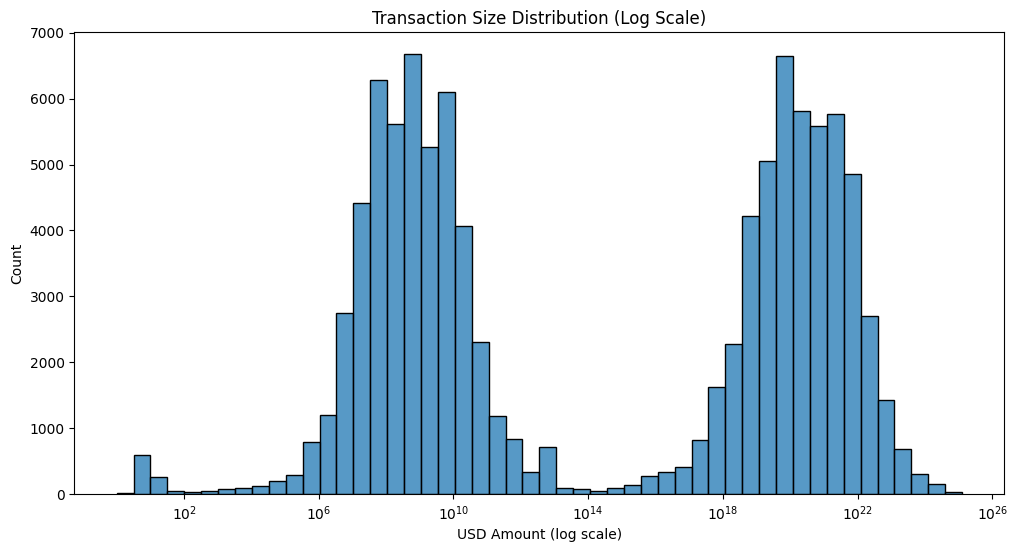

In [27]:
print("\n=== Financial Metrics ===")
print(f"Total USD value transacted: ${df['amount_usd'].sum():,.2f}")
print(f"Average transaction size: ${df['amount_usd'].mean():,.2f}")
print(f"Median transaction size: ${df['amount_usd'].median():,.2f}")

plt.figure(figsize=(12, 6))
sns.histplot(df[df['amount_usd'] > 0]['amount_usd'], bins=50, log_scale=True)
plt.title('Transaction Size Distribution (Log Scale)')
plt.xlabel('USD Amount (log scale)')
plt.ylabel('Count')
plt.show()


=== Top 10 Assets by Transaction Count ===
asset
USDC      29673
DAI       17689
USDT      16019
WETH      11619
WPOL       9254
WMATIC     9051
WBTC       4178
AAVE       2269
            248
Name: count, dtype: int64


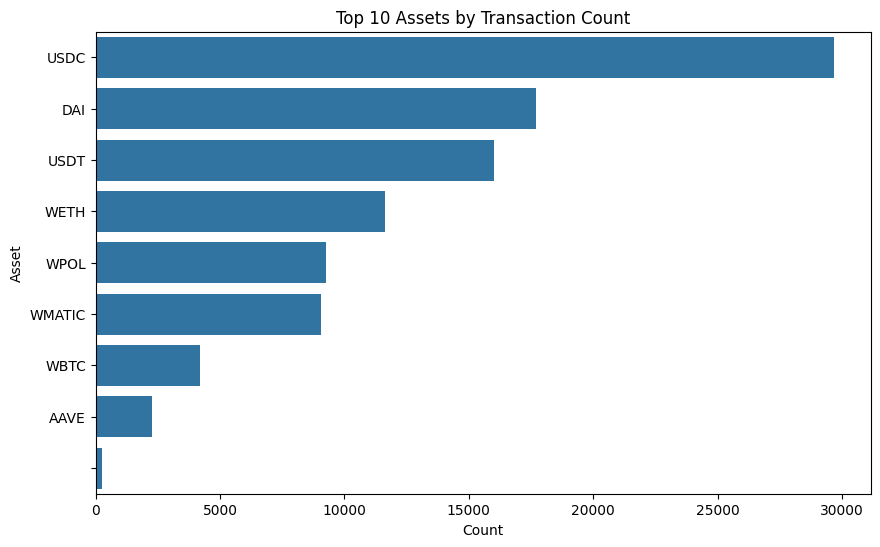

In [28]:
if 'actionData' in df.columns and 'assetSymbol' in df['actionData'].iloc[0]:
    df['asset'] = df['actionData'].apply(lambda x: x.get('assetSymbol', 'Unknown'))

    asset_counts = df['asset'].value_counts()
    print("\n=== Top 10 Assets by Transaction Count ===")
    print(asset_counts.head(10))

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='asset', order=asset_counts.index[:10])
    plt.title('Top 10 Assets by Transaction Count')
    plt.xlabel('Count')
    plt.ylabel('Asset')
    plt.show()


=== Network Distribution ===
network
polygon    100000
Name: count, dtype: int64


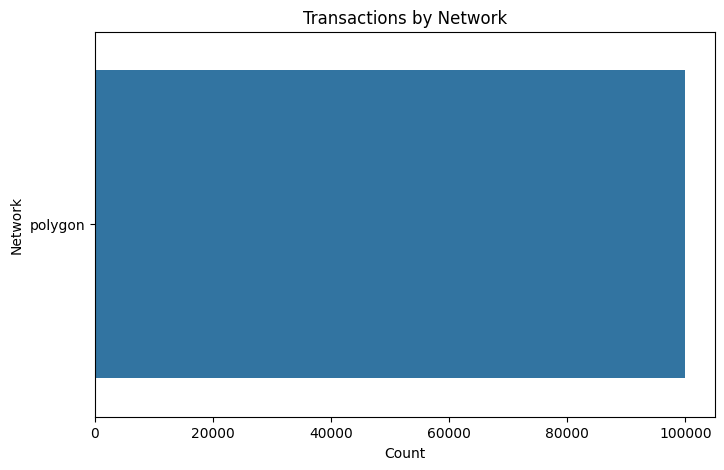

In [29]:
if 'network' in df.columns:
    print("\n=== Network Distribution ===")
    print(df['network'].value_counts())

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, y='network')
    plt.title('Transactions by Network')
    plt.xlabel('Count')
    plt.ylabel('Network')
    plt.show()

In [30]:
if len(df) < 10000:
    fig = px.scatter(df, x='datetime', y='amount_usd', color='action',
                     hover_data=['userWallet', 'asset'],
                     title='Transaction Timeline by Amount and Type',
                     log_y=True)
    fig.show()
else:
    print("\n[Note] Dataset too large for interactive plot - using sampled data")
    sample_df = df.sample(1000)
    fig = px.scatter(sample_df, x='datetime', y='amount_usd', color='action',
                     hover_data=['userWallet', 'asset'],
                     title='Sampled Transaction Timeline by Amount and Type',
                     log_y=True)
    fig.show()



[Note] Dataset too large for interactive plot - using sampled data


In [9]:
def calculate_credit_scores(input_file, output_file):

    try:
        df = pd.read_json(input_file)
    except:
        with open(input_file) as f:
            data = json.load(f)
        df = pd.DataFrame(data)


    required_columns = ['userWallet', 'timestamp', 'action', 'actionData']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in the data")


    df['amount_usd'] = df['actionData'].apply(
        lambda x: float(x['amount']) * float(x['assetPriceUSD']) if 'assetPriceUSD' in x else 0
    )


    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


    features = []

    for wallet, group in df.groupby('userWallet'):
        wallet_data = {}
        wallet_data['wallet'] = wallet
        wallet_data['tx_count'] = len(group)


        time_diff = group['timestamp'].diff().dt.total_seconds().dropna()
        wallet_data['account_age_days'] = (group['timestamp'].max() - group['timestamp'].min()).total_seconds() / 86400
        wallet_data['avg_time_between_tx_hours'] = time_diff.mean() / 3600 if len(time_diff) > 0 else 0
        wallet_data['tx_frequency_per_day'] = wallet_data['tx_count'] / max(1, wallet_data['account_age_days'])


        action_counts = group['action'].str.lower().value_counts(normalize=True)
        for action in ['deposit', 'borrow', 'repay', 'redeem', 'liquidation']:
            wallet_data[f'{action}_ratio'] = action_counts.get(action, 0)


        wallet_data['liquidation_count'] = (group['action'].str.lower() == 'liquidation').sum()
        wallet_data['high_frequency_flag'] = 1 if wallet_data['tx_frequency_per_day'] > 20 else 0


        wallet_data['total_deposited'] = group.loc[group['action'].str.lower() == 'deposit', 'amount_usd'].sum()
        wallet_data['total_borrowed'] = group.loc[group['action'].str.lower() == 'borrow', 'amount_usd'].sum()
        wallet_data['net_position'] = wallet_data['total_deposited'] - wallet_data['total_borrowed']

        features.append(wallet_data)

    features_df = pd.DataFrame(features).fillna(0)


    features_df['activity_score'] = np.log1p(features_df['tx_count']) * 50
    features_df['age_score'] = np.log1p(features_df['account_age_days']) * 30
    features_df['diversity_score'] = (features_df['deposit_ratio'] * 0.4 +
                                    features_df['repay_ratio'] * 0.6) * 100

    features_df['risk_penalty'] = 0
    features_df['risk_penalty'] += features_df['liquidation_count'] * 50
    features_df['risk_penalty'] += features_df['high_frequency_flag'] * 100
    features_df['risk_penalty'] += (1 - features_df['repay_ratio']) * 50

    if len(features_df) > 10:
        clf = IsolationForest(contamination=0.1, random_state=42)
        outliers = clf.fit_predict(features_df.select_dtypes(include=np.number))
        features_df['outlier_penalty'] = np.where(outliers == -1, 300, 0)
    else:
        features_df['outlier_penalty'] = 0


    features_df['raw_score'] = (
        features_df['activity_score'] +
        features_df['age_score'] +
        features_df['diversity_score'] -
        features_df['risk_penalty'] -
        features_df['outlier_penalty']
    )

    features_df['credit_score'] = MinMaxScaler(feature_range=(0, 1000)).fit_transform(
        features_df['raw_score'].values.reshape(-1, 1))


    result = features_df[['wallet', 'credit_score']].sort_values('credit_score', ascending=False)


    result.to_json(output_file, orient='records', indent=2)
    return result

In [10]:
scores = calculate_credit_scores(input_filename, output_filename)

In [11]:
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
print("\nTop 10 wallets by credit score:")
print(scores.head(10))


Top 10 wallets by credit score:
                                          wallet  credit_score
2548  0x046ae0974283a9acf5cb4228a93d000c6d0ffd76   1000.000000
12    0x00000087c4cebffb95746d1935de7fbcab092f40    991.436598
2086  0x03827daa642b7e409e4d08fb34836c22d0a3556b    981.342470
2203  0x03bcc3e7b883f353380babdb76bd914630954a09    980.919682
689   0x011c3a587254b7312d78f2c8ba5adc41a1ed1357    980.714715
1397  0x0255c9d3850caca1152aeb20425c264787661692    978.404638
247   0x005c7aa4001747cd4bf25c777318a13191a182ac    976.569454
489   0x00bbfa640a4bac8f3650373be8f4bd77f0472101    967.493141
418   0x009b21f6f8273fe12dbc9c8025ca27db7de16b8c    963.578163
1274  0x0224b2311d5968fa00a42103788b2f4ccd0651ad    963.211497


In [32]:
scores_df = pd.read_json("/content/aave_credit_scores.json")

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

/tmp/ipython-input-34-1052933643.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




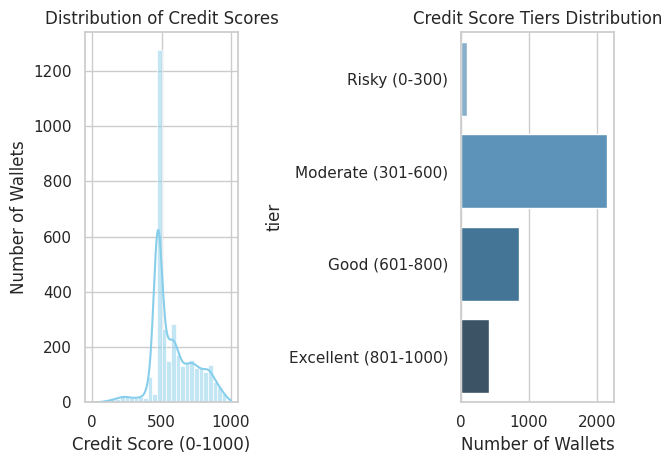

In [34]:
plt.subplot(1, 2, 1)
sns.histplot(scores_df['credit_score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score (0-1000)')
plt.ylabel('Number of Wallets')

plt.subplot(1, 2, 2)
bins = [0, 300, 600, 800, 1000]
labels = ['Risky (0-300)', 'Moderate (301-600)', 'Good (601-800)', 'Excellent (801-1000)']
scores_df['tier'] = pd.cut(scores_df['credit_score'], bins=bins, labels=labels)
tier_counts = scores_df['tier'].value_counts().sort_index()
sns.barplot(x=tier_counts.values, y=tier_counts.index, palette="Blues_d")
plt.title('Credit Score Tiers Distribution')
plt.xlabel('Number of Wallets')

plt.tight_layout()
plt.show()

In [36]:
print("\n🏆 Top 10 Wallets by Credit Score:")
display(scores_df.head(10).style
        .background_gradient(cmap='Blues', subset=['credit_score'])
        .format({'credit_score': '{:.1f}'}))


try:
    import plotly.express as px
    fig = px.box(scores_df, y='credit_score',
                 title='Credit Score Distribution',
                 labels={'credit_score': 'Credit Score'})
    fig.update_layout(yaxis_range=[0,1000])
    fig.show()
except:
    print("\n(Install plotly with '!pip install plotly' for interactive visualizations)")


🏆 Top 10 Wallets by Credit Score:


,wallet,credit_score,tier
0,0x046ae0974283a9acf5cb4228a93d000c6d0ffd76,1000.0,Excellent (801-1000)
1,0x00000087c4cebffb95746d1935de7fbcab092f40,991.4,Excellent (801-1000)
2,0x03827daa642b7e409e4d08fb34836c22d0a3556b,981.3,Excellent (801-1000)
3,0x03bcc3e7b883f353380babdb76bd914630954a09,980.9,Excellent (801-1000)
4,0x011c3a587254b7312d78f2c8ba5adc41a1ed1357,980.7,Excellent (801-1000)
5,0x0255c9d3850caca1152aeb20425c264787661692,978.4,Excellent (801-1000)
6,0x005c7aa4001747cd4bf25c777318a13191a182ac,976.6,Excellent (801-1000)
7,0x00bbfa640a4bac8f3650373be8f4bd77f0472101,967.5,Excellent (801-1000)
8,0x009b21f6f8273fe12dbc9c8025ca27db7de16b8c,963.6,Excellent (801-1000)
9,0x0224b2311d5968fa00a42103788b2f4ccd0651ad,963.2,Excellent (801-1000)


In [9]:
SCORES_FILE = "/content/aave_credit_scores.json"
TRANSACTIONS_FILE = "/content/user-wallet-transactions.json"

In [10]:

def analyze_and_prepare_report(scores_path, transactions_path):

    scores_df = pd.read_json(scores_path)
    tx_df = pd.read_json(transactions_path)


    merged_df = tx_df.merge(scores_df, left_on='userWallet', right_on='wallet')


    bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    labels = ['0-100', '100-200', '200-300', '300-400', '400-500',
              '500-600', '600-700', '700-800', '800-900', '900-1000']

    score_dist = pd.cut(merged_df['credit_score'], bins=bins, labels=labels).value_counts().sort_index()


    tiers = [
        ('Very High Risk (0-300)', (0, 300)),
        ('High Risk (300-500)', (300, 500)),
        ('Medium Risk (500-700)', (500, 700)),
        ('Good (700-850)', (700, 850)),
        ('Excellent (850-1000)', (850, 1000))
    ]

    analysis_data = {
        'metadata': {
            'total_wallets': len(scores_df),
            'total_transactions': len(tx_df),
            'score_ranges': dict(zip(labels, bins[:-1]))
        },
        'score_distribution': score_dist.to_dict(),
        'tier_analysis': {}
    }

    for tier_name, (low, high) in tiers:
        tier_data = merged_df[
            (merged_df['credit_score'] >= low) &
            (merged_df['credit_score'] < high)
        ]


        tier_data['amount_usd'] = tier_data['actionData'].apply(
            lambda x: float(x['amount']) * float(x['assetPriceUSD']) if 'assetPriceUSD' in x else 0
        )

        analysis_data['tier_analysis'][tier_name] = {
            'wallet_count': len(tier_data['userWallet'].unique()),
            'action_distribution': tier_data['action'].value_counts(normalize=True).to_dict(),
            'avg_deposit': tier_data[tier_data['action'] == 'deposit']['amount_usd'].mean(),
            'avg_borrow': tier_data[tier_data['action'] == 'borrow']['amount_usd'].mean(),
            'liquidation_rate': (tier_data['action'] == 'liquidation').mean(),
            'sample_wallets': list(tier_data['userWallet'].unique()[:3])  # First 3 for example
        }


    plt.figure(figsize=(12, 6))
    sns.histplot(merged_df['credit_score'], bins=bins, kde=True)
    plt.title('Credit Score Distribution')
    plt.xlabel('Credit Score')
    plt.ylabel('Number of Wallets')
    plt.savefig('/content/score_distribution.png')


    shareable_data = {
        'summary_stats': {
            'mean_score': merged_df['credit_score'].mean(),
            'median_score': merged_df['credit_score'].median(),
            'score_std': merged_df['credit_score'].std()
        },
        'score_distribution': {k: int(v) for k,v in analysis_data['score_distribution'].items()},
        'tier_analysis': analysis_data['tier_analysis']
    }

    with open('/content/analysis_shareable.json', 'w') as f:
        json.dump(shareable_data, f, indent=2)

    return shareable_data


/tmp/ipython-input-10-3221870686.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tier_data['amount_usd'] = tier_data['actionData'].apply(
/tmp/ipython-input-10-3221870686.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tier_data['amount_usd'] = tier_data['actionData'].apply(
/tmp/ipython-input-10-3221870686.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

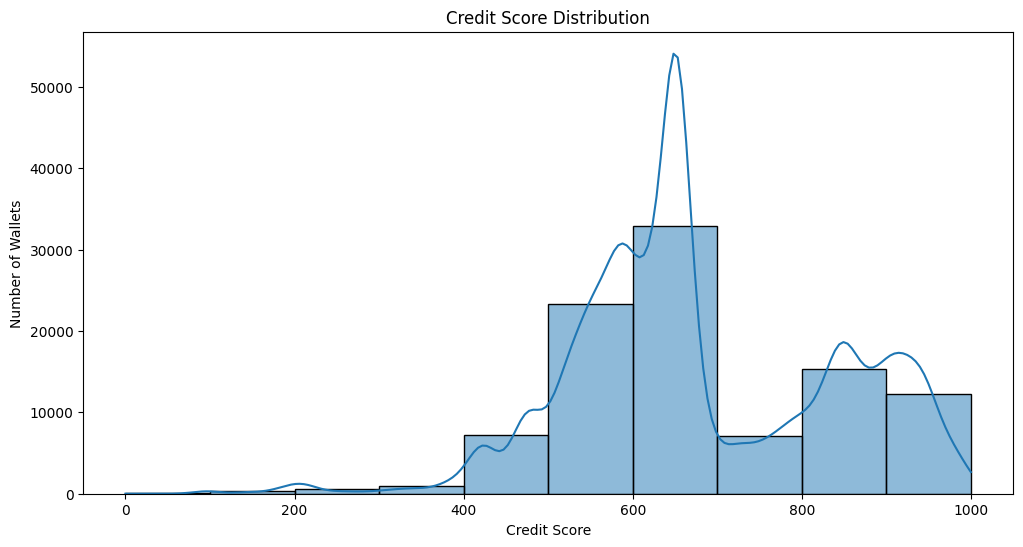

In [11]:
analysis_results = analyze_and_prepare_report(SCORES_FILE, TRANSACTIONS_FILE)

In [12]:
print("Key Analysis Findings:")
print(f"- Mean credit score: {analysis_results['summary_stats']['mean_score']:.1f}")
print(f"- Median credit score: {analysis_results['summary_stats']['median_score']:.1f}")
print("\nScore Distribution:")
for rng, count in analysis_results['score_distribution'].items():
    print(f"{rng}: {count} wallets")

print("\nSample Behavioral Patterns:")
for tier, data in analysis_results['tier_analysis'].items():
    print(f"\n{tier}:")
    print(f"- Wallets: {data['wallet_count']}")
    print(f"- Top action: {max(data['action_distribution'].items(), key=lambda x: x[1])[0]}")
    print(f"- Liquidation rate: {data['liquidation_rate']:.1%}")


Key Analysis Findings:
- Mean credit score: 680.1
- Median credit score: 652.4

Score Distribution:
0-100: 116 wallets
100-200: 325 wallets
200-300: 582 wallets
300-400: 901 wallets
400-500: 7209 wallets
500-600: 23273 wallets
600-700: 32915 wallets
700-800: 7102 wallets
800-900: 15276 wallets
900-1000: 12300 wallets

Sample Behavioral Patterns:

Very High Risk (0-300):
- Wallets: 89
- Top action: redeemunderlying
- Liquidation rate: 0.0%

High Risk (300-500):
- Wallets: 1447
- Top action: deposit
- Liquidation rate: 0.0%

Medium Risk (500-700):
- Wallets: 1147
- Top action: redeemunderlying
- Liquidation rate: 0.0%

Good (700-850):
- Wallets: 583
- Top action: deposit
- Liquidation rate: 0.0%

Excellent (850-1000):
- Wallets: 230
- Top action: deposit
- Liquidation rate: 0.0%


In [13]:
!zip /content/analysis_results.zip /content/analysis_shareable.json /content/score_distribution.png

  adding: content/analysis_shareable.json (deflated 66%)
  adding: content/score_distribution.png (deflated 10%)


In [14]:
from IPython.display import display, HTML
display(HTML(
    """
    <h3>Download Analysis Results</h3>
    <a href="/content/analysis_results.zip" download>
        <button style="background-color:#4CAF50;color:white;padding:10px20px;border:none;cursor:pointer;">
            Download Analysis Package
        </button>
    </a>
    <p>Share this zip file containing:</p>
    <ul>
        <li>analysis_shareable.json - All statistical results</li>
        <li>score_distribution.png - Visualization of score ranges</li>
    </ul>
    """
))


print("\nShareable JSON Data:")
print(json.dumps(analysis_results, indent=2))


Shareable JSON Data:
{
  "summary_stats": {
    "mean_score": 680.102095773947,
    "median_score": 652.4277728566,
    "score_std": 156.65302686540971
  },
  "score_distribution": {
    "0-100": 116,
    "100-200": 325,
    "200-300": 582,
    "300-400": 901,
    "400-500": 7209,
    "500-600": 23273,
    "600-700": 32915,
    "700-800": 7102,
    "800-900": 15276,
    "900-1000": 12300
  },
  "tier_analysis": {
    "Very High Risk (0-300)": {
      "wallet_count": 89,
      "action_distribution": {
        "redeemunderlying": 0.2802734375,
        "deposit": 0.2783203125,
        "borrow": 0.236328125,
        "repay": 0.19921875,
        "liquidationcall": 0.005859375
      },
      "avg_deposit": 2.4006091763597456e+23,
      "avg_borrow": 1.648936216179282e+23,
      "liquidation_rate": 0.0,
      "sample_wallets": [
        "0x00000029ff545c86524ade7caf132527707948c4",
        "0x00001bc47f0973f794f79c16121cee879e272d6a",
        "0x000f7f22bfc28d940d4b68e13213ab17cf107790"
    